In [1]:
import numpy as np
import libaarhusxyz
def read_em_data_from_dat_xyz(em_data, name_gate_times='gate times', dat_type='dat'):
    gate_times = np.array(em_data.info[name_gate_times])
    df_em = em_data.flightlines
    group_em = df_em.groupby('record')
    records = list(group_em.groups.keys())
    df_em_collar = group_em[['line_no','utmx','utmy','timestamp','elevation','alt','tilt']].mean()

    dat_names = ['data_{:d}'.format(ii+1) for ii in range(gate_times.size)]
    df_em[dat_names] = em_data.layer_data['data']
    if dat_type == 'dat':    
        dat_std_names = ['datastd_{:d}'.format(ii+1) for ii in range(gate_times.size)]
        df_em[dat_std_names] = em_data.layer_data['datastd']    

    em_data_nan = em_data.layer_data['data']
    em_data_nan = em_data_nan.replace(9999, np.nan)
    n_ch1_active = np.round((~np.isnan(em_data_nan.loc[df_em[df_em.segment==1].index]).values).sum(axis=1).mean())
    n_ch2_active = np.round((~np.isnan(em_data_nan.loc[df_em[df_em.segment==2].index]).values).sum(axis=1).mean())
    print (f"Active # of channels: Ch1={n_ch1_active:.0f}, Ch2={n_ch2_active:.0f}")

    inds_lm = (~np.isnan(em_data_nan.loc[df_em[df_em.segment==1].index]).values).sum(axis=0) > 0.
    inds_hm = (~np.isnan(em_data_nan.loc[df_em[df_em.segment==2].index]).values).sum(axis=0) > 0.

    data_lm = []
    data_hm = []
    if dat_type == 'dat':
        datastd_lm = []
        datastd_hm = []
    records_inv = []
    for i_record in records:
        df_tmp = group_em.get_group(i_record)
        values = df_tmp[dat_names].values
        if dat_type == 'dat':
            values_std = df_tmp[dat_std_names].values
        if df_tmp.shape[0] == 2:
            i_lm = np.argwhere(df_tmp['segment'].values==1)[0][0]                
            i_hm = np.argwhere(df_tmp['segment'].values==2)[0][0]
            data_lm.append(values[i_lm,inds_lm])
            data_hm.append(values[i_hm,inds_hm])
            if dat_type == 'dat':
                datastd_lm.append(values_std[i_lm,inds_lm])
                datastd_hm.append(values_std[i_hm,inds_hm])        
            records_inv.append(i_record)
    data_lm = np.vstack(data_lm)
    data_hm = np.vstack(data_hm)
    if dat_type == 'dat':
        datastd_lm = np.vstack(datastd_lm)
        datastd_hm = np.vstack(datastd_hm)
    records_inv = np.hstack(records_inv)
    df_em_inv = df_em_collar.loc[records_inv]
    times_lm_inv = gate_times[inds_lm]
    times_hm_inv = gate_times[inds_hm]    

    ch1_names = ['dbdt_ch1gt_{:d}'.format(ii+1) for ii in range(data_lm.shape[1])]
    ch2_names = ['dbdt_ch2gt_{:d}'.format(ii+1) for ii in range(data_hm.shape[1])]
    if dat_type == 'dat':    
        std_ch1_names = ['dbdt_std_ch1gt_{:d}'.format(ii+1) for ii in range(data_lm.shape[1])]
        std_ch2_names = ['dbdt_std_ch2gt_{:d}'.format(ii+1) for ii in range(data_hm.shape[1])]    

    df_em_inv[ch1_names] = data_lm
    df_em_inv[ch2_names] = data_hm
    if dat_type == 'dat':    
        df_em_inv[std_ch1_names] = datastd_lm
        df_em_inv[std_ch2_names] = datastd_hm
    
    meta_data_dict = {}
    meta_data_dict['ch1_names'] = ch1_names
    meta_data_dict['ch2_names'] = ch2_names
    if dat_type == 'dat':    
        meta_data_dict['std_ch1_names'] = std_ch1_names
        meta_data_dict['std_ch2_names'] = std_ch1_names
    meta_data_dict['ch1_times'] = times_lm_inv
    meta_data_dict['ch2_times'] = times_hm_inv
    df_em_inv = df_em_inv.replace(9999, np.nan)
    return df_em_inv, meta_data_dict

In [2]:
fname = "../salinas_2017/MCWD3_SCI1i_MOD_dat.xyz"
aem_data = libaarhusxyz.XYZ(fname)

fname = "../salinas_2017/MCWD3_SCI1i_MOD_syn.xyz"
aem_data_syn = libaarhusxyz.XYZ(fname)
list(aem_data.info.keys())

['dummy',
 'data unit',
 'data type',
 'coordinate system',
 'number of layers',
 'model unit',
 'length unit',
 'number of gates',
 'gate times (s)',
 'source']

In [3]:
fname = "../salinas_2017/MCWD3_SCI1i_MOD_inv.xyz"
aem_model = libaarhusxyz.XYZ(fname)

In [4]:
df_em_inv, meta_data_dict = read_em_data_from_dat_xyz(aem_data, name_gate_times='gate times (s)')

Active # of channels: Ch1=18, Ch2=25


In [5]:
df_em_syn, _ = read_em_data_from_dat_xyz(aem_data_syn, name_gate_times='gate times (s)', dat_type='syn')

Active # of channels: Ch1=18, Ch2=25


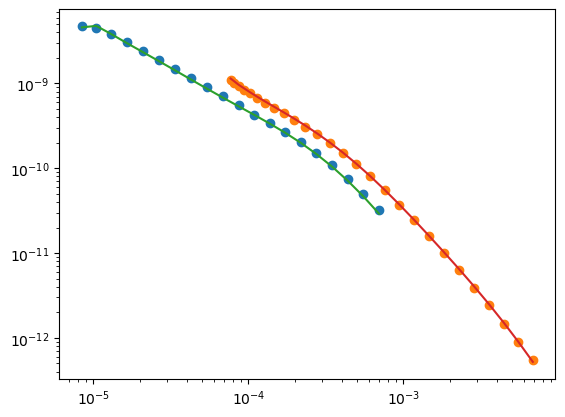

In [34]:
import matplotlib.pyplot as plt
ch1_names = meta_data_dict['ch1_names']
ch2_names = meta_data_dict['ch2_names']
times_ch1 = meta_data_dict['ch1_times']
times_ch2 = meta_data_dict['ch2_times']

record_tmp = 1000
plt.loglog(times_ch1, df_em_inv.loc[record_tmp][ch1_names], 'o')
plt.loglog(times_ch2, df_em_inv.loc[record_tmp][ch2_names], 'o')
plt.loglog(times_ch1, df_em_syn.loc[record_tmp][ch1_names], '-')
plt.loglog(times_ch2, df_em_syn.loc[record_tmp][ch2_names], '-')

In [35]:
df_rho_collar = aem_model.flightlines
rho = aem_model.layer_data['rho_i'].loc[df_rho_collar[df_rho_collar['record']==record_tmp].index].values.flatten()
thickness = aem_model.layer_data['thk'].loc[df_rho_collar[df_rho_collar['record']==record_tmp].index].values.flatten()

In [36]:
system = libaarhusxyz.parse_gex("../salinas_2017/20170606_337m2_Cal_DualWaveform_60Hz_414_412_418.gex")
area = system['General']['TxLoopArea']
waveform_hm = system['General']['WaveformHMPoint']
waveform_lm = system['General']['WaveformLMPoint']
i_start_hm = int(system['Channel2']['RemoveInitialGates'])
i_start_lm = int(system['Channel1']['RemoveInitialGates'])
time_input_currents_hm = waveform_hm[:,0]
input_currents_hm = waveform_hm[:,1]
time_input_currents_lm = waveform_lm[:,0]
input_currents_lm = waveform_lm[:,1]

time_gates = system['General']['GateTime']
GateTimeShift=system['Channel1']['GateTimeShift']
MeaTimeDelay=system['Channel1']['MeaTimeDelay']
NoGates=int(system['Channel1']['NoGates'])
t0_lm = waveform_lm[:,0].max()
times_lm = (time_gates[:NoGates,0] + GateTimeShift + MeaTimeDelay)[i_start_lm:]
GateTimeShift=system['Channel2']['GateTimeShift']
MeaTimeDelay=system['Channel2']['MeaTimeDelay']
NoGates=int(system['Channel2']['NoGates'])
t0_hm = waveform_hm[:,0].max()
times_hm = (time_gates[:NoGates,0] + GateTimeShift + MeaTimeDelay)[i_start_hm:]

header [General] parsed
header [Channel1] parsed
header [Channel2] parsed


In [37]:
times_ch2

array([7.681e-05, 8.131e-05, 8.641e-05, 9.382e-05, 1.028e-04, 1.143e-04,
       1.288e-04, 1.468e-04, 1.693e-04, 1.973e-04, 2.328e-04, 2.783e-04,
       3.353e-04, 4.073e-04, 4.983e-04, 6.123e-04, 7.563e-04, 9.378e-04,
       1.167e-03, 1.455e-03, 1.819e-03, 2.278e-03, 2.856e-03, 3.575e-03,
       4.455e-03, 5.532e-03, 6.850e-03, 8.464e-03])

In [38]:
# source_height = df_em_inv.loc[record_tmp]['alt']
source_height = df_rho_collar[df_rho_collar['record']==record_tmp]['invalt'].values[0]

In [39]:
system['General']['RxCoilLPFilter']

array([9.9e-01, 2.1e+05])

In [40]:
system['Channel1']['TiBLowPassFilter']

array([1.e+00, 3.e+05])

In [41]:
system['Channel2']['TiBLowPassFilter']

array([1.e+00, 3.e+05])

In [49]:
from discretize import TensorMesh
import numpy as np
from SimPEG import maps
import SimPEG.electromagnetics.time_domain as tdem
from SimPEG.electromagnetics.utils.em1d_utils import plot_layer, set_mesh_1d

# Source properties
source_location = np.array([0., 0., source_height])  
source_orientation = "z"                      # "x", "y" or "z"
source_current = 1.                           # maximum on-time current

# Receiver properties
receiver_location = np.array([13.25, 0., source_height+2.])
receiver_orientation = "z"                    # "x", "y" or "z"
# Receiver list
# Define receivers at each location.
receivers_lm_list = [
    tdem.receivers.PointMagneticFluxTimeDerivative(
        receiver_location, times_ch1, "z",
        lp_cutoff_frequency_1=3e5,
        lp_power_1=1,
        lp_cutoff_frequency_2=2.1e5,
        lp_power_2=0.99,        
    ),
]  # Make a list containing all receivers even if just one
receivers_hm_list = [
    tdem.receivers.PointMagneticFluxTimeDerivative(
        receiver_location, times_ch2, "z",
        lp_cutoff_frequency_1=3e5,
        lp_power_1=1,
        lp_cutoff_frequency_2=2.1e5,
        lp_power_2=0.99,        
    ),
]  # Make a list containing all receivers even if just one

waveform_lm = tdem.sources.PiecewiseLinearWaveform(
        times=time_input_currents_lm, currents=input_currents_lm
)
waveform_hm = tdem.sources.PiecewiseLinearWaveform(
        times=time_input_currents_hm, currents=input_currents_hm
)
# Must define the transmitter properties and associated receivers
source_list = [
    tdem.sources.MagDipole(
        receivers_lm_list,
        location=source_location,
        waveform=waveform_lm,
    ),
    tdem.sources.MagDipole(
        receivers_hm_list,
        location=source_location,
        waveform=waveform_hm,
    ),    
]

survey = tdem.Survey(source_list)
# Define the simulation
simulation = tdem.Simulation1DLayered(
    survey=survey, thicknesses=thickness, sigma=1./rho,
)
# %%time
dpred = simulation.dpred([])  

/Users/sgkang09/Project/simpeg/SimPEG/props.py:369: UserWarning: Cannot add model as there are no active mappings, choose from: ['cMap', 'etaMap', 'hMap', 'muMap', 'rhoMap', 'sigmaMap', 'tauMap', 'thicknessesMap']
  warnings.warn(


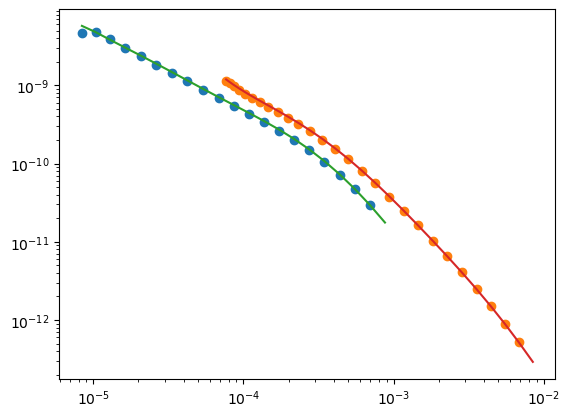

In [50]:
plt.loglog(times_ch1, df_em_syn.loc[record_tmp][ch1_names], 'o')
plt.loglog(times_ch2, df_em_syn.loc[record_tmp][ch2_names], 'o')
plt.loglog(times_ch1, -dpred[:len(ch1_names)], '-')
plt.loglog(times_ch2, -dpred[len(ch1_names):], '-')